In [ ]:
import sys
import os
IN_COLAB = 'google.colab' in sys.modules

data_path = "./"
if IN_COLAB:
    data_path = '/content/Prague_ml'
    if os.path.exists(data_path):
        print("Prague_ml already exists")
    else:
        ! git clone https://github.com/VarunBurde/Prague_ml

### Image formation 
We know the properties of light and optics, and how rays travel from the light source to a screen to form an image. A camera works on the same principle, but instead of a screen, it captures the light rays on a sensor and transforms them into RGB pixel values.


![Image formation in pinhole camera](visulization_data/Pinhole-camera.png)


Light rays from a scene travel and converge at the image plane, where a sharp image is formed. The optical center is the point from which these rays appear to diverge. The focal length is the distance from this point to the image plane, affecting how the scene is scaled in the image


### Camera Intrinsics

The camera intrinsic matrix (K) describes how 3D points in camera coordinates are projected onto the 2D image plane:

$$K = \begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}$$

Where:
- $f_x$, $f_y$: Focal length in pixels (in x and y directions)
- $c_x$, $c_y$: Principal point coordinates (optical center on the image plane)

This matrix encapsulates the internal optical characteristics of the camera, independent of the camera's position and orientation in the world.

For more information, see: [Camera Parameters in Computer Vision](https://towardsdatascience.com/what-are-intrinsic-and-extrinsic-camera-parameters-in-computer-vision-7071b72fb8ec/)

### Camera Extrinsics

![Image Plane](visulization_data/intrnsics.png)

When a 3D point at coordinates **(x, y, z)** in Cartesian space is projected onto the 2D image plane, it undergoes a transformation from world space to image (pixel) space **(u, v)**. This transformation involves a rotation **R** and translation **T**, and is represented by the **projection matrix**:
$$\begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = P \begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix} = K[R|T] \begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix}$$

Where:

- **K** is the intrinsic camera matrix (describing internal parameters),
- **R** is the rotation matrix,
- **T** is the translation vector.

In theory, this allows us to map 3D world coordinates to 2D image coordinates. However, the inverse mapping—from **(u, v)** back to **(x, y, z)**—is not directly possible because the projection is a many-to-one transformation. This loss of depth information makes it non-symmetric and inherently **ill-posed**, which is one of the core challenges in 3D computer vision and depth reconstruction.




### Lens and Distortion

### Understanding Optical Aberrations

Lens distortions are optical aberrations that cause straight lines in the real world to appear curved in captured images. These distortions are not defects but natural consequences of the physical properties and design of camera lenses.

When light passes through a lens, its path can be altered in ways that don't perfectly preserve the straight-line geometry of the original scene. These aberrations become particularly noticeable in images containing straight lines, especially near the edges of the frame.

![Lens Distortion Example](visulization_data/distorted_image.jpg)
## Do you see the straight lines? Do you think the image is distorted or does the dancing house windows not follow straight lines?

### Key Points:

- **Physical Cause**: Results from the geometric properties of lens elements
- **Impact**: Affects measurements, geometric accuracy, and visual aesthetics
- **Variability**: Different lens types exhibit different characteristic distortions
- **Correctability**: Can be mathematically modeled and corrected in post-processing

### Further Reading

- [Types of Distortion and Measurement Methods](https://www.image-engineering.de/library/image-quality/factors/1062-distortion)
- [Camera Visualization and Calibration](https://docs.nerf.studio/nerfology/model_components/visualize_cameras.html)

## Try to play with distortion values and see if you ever saw such distortion before

### Types of Lens Distortions



### 1. Barrel Distortion

**Causes:**
- Occurs when magnification decreases as you move away from the optical center
- Common in wide-angle lenses
- Lines appear to bow outward like a barrel

**Correction Method:**
- Can be modeled using radial distortion coefficients (k1, k2, k3)
- Corrected using the equation: x_corrected = x(1 + k1*r² + k2*r⁴ + k3*r⁶)

![Image Description](visulization_data/barrel_dist.png)

**Calibration Views Needed:**
- Straight-on (front-facing) views with checkerboard pattern
- Close-up views particularly effective

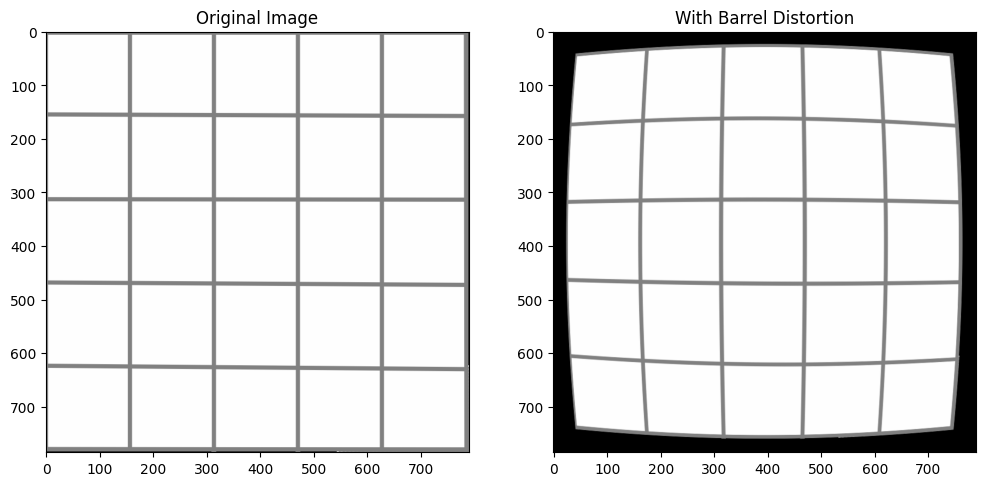

In [2]:
# Example of barrel distortion visualization
import numpy as np
import cv2
import matplotlib.pyplot as plt

def create_barrel_distortion(img, k1=-0.3):
    """Apply synthetic barrel distortion to an image"""
    h, w = img.shape[:2]
    # Create camera matrix
    cam_mat = np.array([[w, 0, w/2],
                       [0, w, h/2],
                       [0, 0, 1]])
    
    # Distortion coefficients [k1, k2, p1, p2, k3]
    dist_coeffs = np.array([k1, 0, 0, 0, 0])
    
    # Apply distortion
    distorted = cv2.undistort(img, cam_mat, -dist_coeffs)  # Negative to create distortion
    return distorted

# Example usage (commented out until we have an image)
img_path = os.path.join(data_path, 'visulization_data', 'sample_grid.png')  # Replace with your image path
img = cv2.imread(img_path)
if img is not None:
    barrel_img = create_barrel_distortion(img)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[1].imshow(cv2.cvtColor(barrel_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title('With Barrel Distortion')
    plt.show()

## 2. Pincushion Distortion

**Causes:**
- Occurs when magnification increases as you move away from the optical center
- Common in telephoto lenses
- Lines curve inward like a pincushion

**Correction Method:**
- Uses the same radial distortion model as barrel distortion but with opposite sign coefficients
- Software correction algorithms in post-processing

![Pincushion Distortion](visulization_data/pincu_dist.png)

**Calibration Views Needed:**
- Distant views of calibration pattern
- Edge-of-frame views to capture maximum distortion

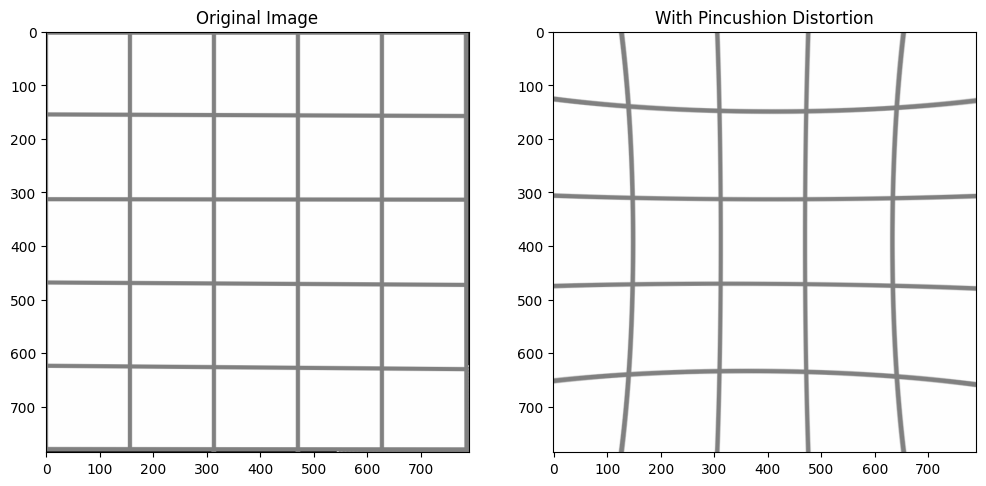

In [3]:
# Example of pincushion distortion visualization
def create_pincushion_distortion(img, k1=0.3):
    """Apply synthetic pincushion distortion to an image"""
    h, w = img.shape[:2]
    # Create camera matrix
    cam_mat = np.array([[w, 0, w/2],
                       [0, w, h/2],
                       [0, 0, 1]])
    
    # Distortion coefficients [k1, k2, p1, p2, k3]
    dist_coeffs = np.array([k1, 0, 0, 0, 0])
    
    # Apply distortion
    distorted = cv2.undistort(img, cam_mat, -dist_coeffs)  # Negative to create distortion
    return distorted

# Example usage (commented out until we have an image)
img = cv2.imread(img_path)
if img is not None:
    pincushion_img = create_pincushion_distortion(img)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[1].imshow(cv2.cvtColor(pincushion_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title('With Pincushion Distortion')
    plt.show()

## 3. Mustache Distortion

**Causes:**
- Complex aberrations in lens design
- Combination of barrel and pincushion distortions
- Common in zoom lenses

**Correction Method:**
- Requires higher-order polynomial models
- Often needs both radial and tangential distortion coefficients

![Mustache Distortion](visulization_data/mustach_dist.jpg)

**Calibration Views Needed:**
- Angled views of calibration pattern
- Multiple perspectives to capture transition between distortion types

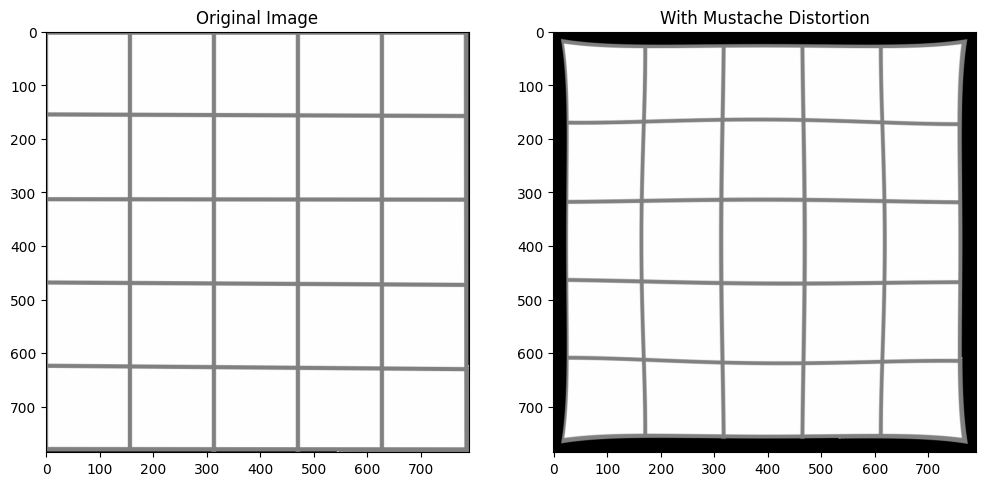

In [4]:
# Example of mustache distortion visualization
def create_mustache_distortion(img, k1=-0.5, k2=0.9):
    """Apply synthetic mustache distortion to an image"""
    h, w = img.shape[:2]
    # Create camera matrix
    cam_mat = np.array([[w, 0, w/2],
                       [0, w, h/2],
                       [0, 0, 1]])
    
    # Distortion coefficients [k1, k2, p1, p2, k3]
    dist_coeffs = np.array([k1, k2, 0, 0, 0])
    
    # Apply distortion
    distorted = cv2.undistort(img, cam_mat, -dist_coeffs)  # Negative to create distortion
    return distorted

# Example usage (commented out until we have an image)
img = cv2.imread(img_path)
if img is not None:
    mustache_img = create_mustache_distortion(img)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[1].imshow(cv2.cvtColor(mustache_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title('With Mustache Distortion')
    plt.show()

## 4. Tangential (Decentering) Distortion

**Causes:**
- Lens not perfectly aligned with camera sensor
- Optical elements inside lens are misaligned
- Creates asymmetrical distortion

![Tangential (Decentering) Distortion](visulization_data/tang_dist_1.png)

**Correction Method:**
- Modeled using tangential distortion coefficients (p1, p2)
- Correction equations:
  - x_corrected = x + [2p1xy + p2(r² + 2x²)]
  - y_corrected = y + [p1(r² + 2y²) + 2p2xy]

![Tangential (Decentering) Distortion](visulization_data/tang_dist_2.png)

**Calibration Views Needed:**
- Tilted and rotated views of calibration pattern
- Multiple orientations to detect asymmetries

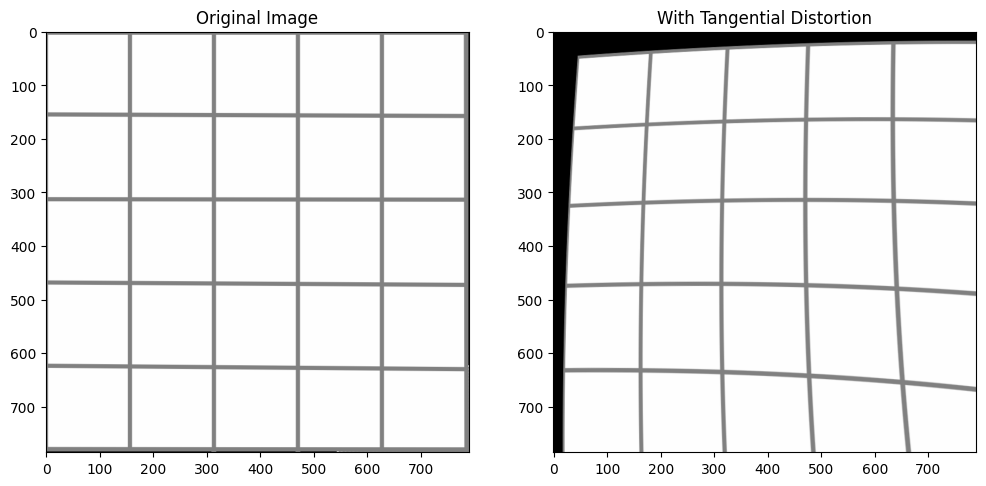

In [9]:
# Example of tangential distortion visualization
def create_tangential_distortion(img, p1=0.05, p2=0.05):
    """Apply synthetic tangential distortion to an image"""
    h, w = img.shape[:2]
    # Create camera matrix
    cam_mat = np.array([[w, 0, w/2],
                       [0, w, h/2],
                       [0, 0, 1]])
    
    # Distortion coefficients [k1, k2, p1, p2, k3]
    dist_coeffs = np.array([0, 0, p1, p2, 0])
    
    # Apply distortion
    distorted = cv2.undistort(img, cam_mat, -dist_coeffs)  # Negative to create distortion
    return distorted

# Example usage (commented out until we have an image)
img = cv2.imread(img_path)
if img is not None:
    tangential_img = create_tangential_distortion(img)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[1].imshow(cv2.cvtColor(tangential_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title('With Tangential Distortion')
    plt.show()

### Camera Calibration and Reprojection Error Calculation

In this section, we'll perform camera calibration using checkerboard images and calculate the reprojection error.

In [ ]:
import cv2
import numpy as np
import glob
import os

def calibrate_camera(image_dir, checkerboard_size=(8, 5)):
    """Calibrate the camera and calculate reprojection error."""
    # Termination criteria for corner sub-pixel accuracy
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # Prepare object points (e.g., (0,0,0), (1,0,0), ..., (8,5,0))
    chessboard_sq_size = 30 # Size of a chessboard square in mm
    objp = np.zeros((checkerboard_size[0] * checkerboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:checkerboard_size[0], 0:checkerboard_size[1]].T.reshape(-1, 2) * chessboard_sq_size

    # Arrays to store object points and image points
    objpoints = []  # 3D points in real world space
    imgpoints_detected = []  # 2D points in image plane

    # Load all images from the directory
    images = image_dir

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)

        if ret:
            objpoints.append(objp)
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints_detected.append(corners2)

    # Perform camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints_detected, gray.shape[::-1], None, None)

    # Calculate reprojection error
    total_error = 0
    imgpoints_reproj = []
    for i in range(len(objpoints)):
        imgpoints_reproj_, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        imgpoints_reproj.append(imgpoints_reproj_)

        norm = np.linalg.norm(imgpoints_detected[i][:, 0] - imgpoints_reproj_[:, 0], axis=1)
        
        total_error += np.mean(norm)

    mean_error = total_error / len(objpoints)

    return mtx, dist, mean_error, imgpoints_detected, imgpoints_reproj, rvecs, tvecs

# Analyze distortion coefficients
def analyze_distortion(dist_coeffs):
    """
    Analyze distortion coefficients to determine the type of lens distortion.
    
    Args:
        dist_coeffs: Array of distortion coefficients from camera calibration
    
    Returns:
        str: Description of the dominant distortion type
    """
    k1, k2, p1, p2, k3 = dist_coeffs.flatten()
    
    if k1 < 0 and abs(k1) > abs(k2):
        return "Barrel distortion is dominant (negative k1)"
    elif k1 > 0 and abs(k1) > abs(k2):
        return "Pincushion distortion is dominant (positive k1)"
    elif abs(p1) > 0.01 or abs(p2) > 0.01:
        return "Tangential distortion is present (p1 or p2 not close to zero)"
    else:
        return "No significant distortion detected"


# Example usage
if IN_COLAB:
  image_directory = "/content/Prague_ml/dataset/chessboard"
else:
  image_directory = "./dataset/chessboard"

frontal_images = [os.path.join(image_directory, "frontal", img_name) 
                  for img_name in os.listdir(os.path.join(image_directory, "frontal"))]


intrinsic_matrix, distortion_coeffs, reprojection_error, imgpoints_det, imgpoints_reproj, rvecs, tvecs = calibrate_camera(frontal_images)

print("\n--- Calibration Results for Frontal Images ---")
print(f"Reprojection Error: {reprojection_error:.4f}")
print(f"Distortion Coefficients: {distortion_coeffs}")
print(f"Distortion Analysis: {analyze_distortion(distortion_coeffs)}")

corner_images = [os.path.join(image_directory, "corner", img_name) 
                  for img_name in os.listdir(os.path.join(image_directory, "corner"))]

intrinsic_matrix, distortion_coeffs, reprojection_error, imgpoints_det, imgpoints_reproj, rvecs, tvecs = calibrate_camera(corner_images)

print("\n--- Calibration Results for Corner Images ---")
print(f"Reprojection Error: {reprojection_error:.4f}")
print(f"Distortion Coefficients: {distortion_coeffs}")
print(f"Distortion Analysis: {analyze_distortion(distortion_coeffs)}")

tilted_images = [os.path.join(image_directory, "tilted", img_name) 
                  for img_name in os.listdir(os.path.join(image_directory, "tilted"))]


intrinsic_matrix, distortion_coeffs, reprojection_error, imgpoints_det, imgpoints_reproj, rvecs, tvecs = calibrate_camera(tilted_images)

print("\n--- Calibration Results for Tilted Images ---")
print(f"Reprojection Error: {reprojection_error:.4f}")
print(f"Distortion Coefficients: {distortion_coeffs}")
print(f"Distortion Analysis: {analyze_distortion(distortion_coeffs)}")


# all images
all_images = frontal_images + corner_images + tilted_images
intrinsic_matrix, distortion_coeffs, reprojection_error, imgpoints_det, imgpoints_reproj, rvecs, tvecs = calibrate_camera(all_images)

print("\n--- Calibration Results for All Images ---")
print(f"Reprojection Error: {reprojection_error:.4f}")
print(f"Distortion Coefficients: {distortion_coeffs}")
print(f"Distortion Analysis: {analyze_distortion(distortion_coeffs)}")



--- Calibration Results for Frontal Images ---
Reprojection Error: 0.2944
Distortion Coefficients: [[ 2.64856907e+00 -9.54135348e+01 -1.84857273e-02  6.31909972e-04
   4.88524512e+02]]
Distortion Analysis: Tangential distortion is present (p1 or p2 not close to zero)

--- Calibration Results for Corner Images ---
Reprojection Error: 0.4320
Distortion Coefficients: [[ 7.87483987e+00 -8.43504913e+02  2.36341538e-02 -9.43517198e-03
   2.80044377e+04]]
Distortion Analysis: Tangential distortion is present (p1 or p2 not close to zero)

--- Calibration Results for Tilted Images ---
Reprojection Error: 0.2023
Distortion Coefficients: [[ 1.10336582e-01  7.47376176e-01  1.39624093e-03  8.21703075e-04
  -5.08375498e+00]]
Distortion Analysis: No significant distortion detected

--- Calibration Results for All Images ---
Reprojection Error: 0.2871
Distortion Coefficients: [[ 2.27949062e-01 -8.53190139e-01 -4.31064144e-04  7.77112689e-04
   9.12453860e-01]]
Distortion Analysis: No significant dist

# Camera extrinsics

It's the transformation from object world to the camera. Camera extrinsics consist of rotation (R) and translation (t) matrices that define the camera's position and orientation in 3D world coordinates.

In [ ]:


def visualize_scene_with_cameras(intrinsic_matrix, distortion_coeffs, camera_poses, scale=1.0, imgpoints_det=None, imgpoints_reproj=None, all_images=None):
    """Visualize 3D points, camera positions, and reprojection in a single plot with the actual camera image"""
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import cv2


    # Create figure with subplots - 3D scene on left, camera image on right
    fig = make_subplots(
        rows=1, cols=2,
        column_widths=[0.5, 0.5],
        specs=[[{"type": "scene"}, {"type": "image"}]],
        subplot_titles=["Detected Pixels and Reprojected Pixels", "Camera Image"]
    )
    
    
    # Add world coordinate frame (chessboard frame)
    # axes_length = scale
    axes_colors = ['darkgreen', 'darkred', 'darkblue']
    axes_names = ['Y_world', 'X_world', 'Z_world']
    
    # Origin of world coordinates (chessboard origin)
    world_origin = np.array([imgpoints_det[0, 0, 0], imgpoints_det[0, 0, 1], 0]) * scale
    
    # Draw world coordinate axes - for chessboard, Z should point UP perpendicular to board
    for axis in range(3):
        direction = np.zeros(3)
        direction[axis] = 10.0
        
        fig.add_trace(go.Scatter3d(
            x=[world_origin[0], world_origin[0] - direction[0]],
            y=[world_origin[1], world_origin[1] + direction[1]],
            z=[world_origin[2], world_origin[2] - direction[2]],
            mode='lines+text',
            line=dict(color=axes_colors[axis], width=5),
            text=['', axes_names[axis]],
            textposition='top center',
            showlegend=False
        ), row=1, col=1)
    
    
    # Add detected and reprojected points near the chessboard
    if imgpoints_det is not None and imgpoints_reproj is not None and len(imgpoints_det) > 0:

        # We need to actually access the global variable since we don't have it as a parameter
        
        # Detected points (blue)
        if len(imgpoints_det[0]) > 0:
            # Extract 2D image points
            img_pts = imgpoints_det.reshape(-1, 2) * scale
            
            # For each image point, project a ray from camera to chessboard
            world_pts_detected = []
            
            for point_det in img_pts:
                # The corresponding 3D point in world coordinates (from original points)
      
                pt3d = np.array([point_det[0], point_det[1], 1.0])  # Assuming Z=0 for chessboard plane
                world_pts_detected.append(pt3d)  # Offset in Z
            
            # Convert to numpy array
            world_pts_detected = np.array(world_pts_detected)
            # print(world_pts_detected)
            # Add detected points to plot
            fig.add_trace(go.Scatter3d(
                x=world_pts_detected[:, 0],
                y=world_pts_detected[:, 1],
                z=world_pts_detected[:, 2],
                mode='markers',
                marker=dict(
                    size=3,
                    color='green',
                    symbol='circle'
                ),
                name='Detected Pixels'
            ), row=1, col=1)
            
        # Reprojected points (red)
        if imgpoints_reproj is not None:
            # Handle the case where imgpoints2 is a list
            if isinstance(imgpoints_reproj, list):
                # Extract the first element if it's a list
                imgpoints2_data = imgpoints_reproj[0]
            else:
                imgpoints2_data = imgpoints_reproj
                
            # Extract 2D reprojected points
            reproj_pts = imgpoints2_data.reshape(-1, 2) * scale
            
            # For each reprojected point, create a visual point
            world_pts_reprojected = []
            for point_det in reproj_pts:
                # The corresponding 3D point in world coordinates
                # Create a slightly offset point to visualize reprojected points
                pt3d = np.array([point_det[0], point_det[1], 0.0])
                
                world_pts_reprojected.append(pt3d)  # Higher offset in Z
            
            # Convert to numpy array
            world_pts_reprojected = np.array(world_pts_reprojected)
            # print("reprojected", world_pts_reprojected)
            # Add reprojected points to plot
            fig.add_trace(go.Scatter3d(
                x=world_pts_reprojected[:, 0],
                y=world_pts_reprojected[:, 1],
                z=world_pts_reprojected[:, 2],
                mode='markers',
                marker=dict(
                    size=3,
                    color='blue',
                    symbol='circle'
                ),
                name='Reprojected Pixels'
            ), row=1, col=1)

    axis = np.float32([[0, 0, 0],
                        [25, 0, 0],
                        [0, 25, 0],
                        [0, 0, -25]])
    
    # Add the camera image if provided
    if all_images is not None and len(all_images) > 0:
        # Read the image and convert it to RGB
        img = cv2.imread(all_images[0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        coord_axes, _ = cv2.projectPoints(axis, camera_poses[:3, :3], camera_poses[:, 3], intrinsic_matrix, distortion_coeffs)
        coord_axes = coord_axes.reshape(-1, 2).astype(int)
        cv2.line(img, tuple(coord_axes[0]), tuple(coord_axes[1]), (255, 0, 0), 4)  # X-axis in red
        cv2.line(img, tuple(coord_axes[0]), tuple(coord_axes[2]), (0, 255, 0), 4)  # Y-axis in green
        cv2.line(img, tuple(coord_axes[0]), tuple(coord_axes[3]), (0, 0, 255), 4)  # Z-axis in blue
        if img is not None:
            for point_det, point_reproj in zip(imgpoints_det, imgpoints_reproj):
                x_det = round(point_det[0][0])
                y_det = round(point_det[0][1])

                x_reproj = round(point_reproj[0][0])
                y_reproj = round(point_reproj[0][1])
                # Draw detected points on the image

                
                cv2.circle(img, (x_reproj, y_reproj), 7, (0, 0, 255), -1)
                cv2.circle(img, (x_det, y_det), 7, (0, 255, 0), -1)
            # Resize the image to reduce memory usage
            max_dim = 640  # Maximum dimension
            h, w = img.shape[:2]
            if h > max_dim or w > max_dim:
                # Calculate the resize factor
                factor = max_dim / max(h, w)
                img = cv2.resize(img, (int(w * factor), int(h * factor)))
            
            

            #Add image to the right subplot
            fig.add_trace(
                go.Image(
                    z=img,
                    name="Camera Image"
                ),
                row=1, col=2
            )
    
    # Setup layout with better camera position
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            # Set initial camera viewpoint for better visualization
            camera=dict(
                eye=dict(x=2.5, y=2.5, z=1.5),  # Viewpoint further back to see everything
                up=dict(x=0, y=0, z=1)  # Z-up view
            ),
            aspectmode='data'
        ),
        width=1280,  # Wider for better view
        height=720,
        # title="Camera Calibration Visualization with Reprojection Errors",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center", 
            x=0.5
        )
    )
    
    # Update image subplot
    fig.update_xaxes(showticklabels=False, row=1, col=2)
    fig.update_yaxes(showticklabels=False, row=1, col=2)
    
    return fig

### Camera Extrinsics Visualization: Understanding Projection Errors

The visualizations in the next cell demonstrate how lens distortion and inaccuracies in the projection matrix contribute to errors in image reconstruction. Each visualization shows:

1. **Detected Points (Green)**: The actual points detected in the image
2. **Reprojected Points (Blue)**: Where the camera model predicts these points should appear

The difference between blue and green points represents the reprojection error, which quantifies the accuracy of our camera model. Higher errors indicate:

- Uncorrected lens distortions
- Imprecise camera calibration
- Limitations in the mathematical model

These visualizations help us understand why perfect 3D reconstruction from 2D images is challenging and why multiple views and robust algorithms are necessary for accurate results.

In [ ]:

# Prepare camera poses for visualization
camera_poses = []
for r, t in zip(rvecs, tvecs):
    # Convert rotation vector to rotation matrix
    R, _ = cv2.Rodrigues(r)
    # Create full camera pose [R|t]
    pose = np.hstack((R, t))
    camera_poses.append(pose)


# Visualize each camera separately with its reprojection errors
for i in range(len(camera_poses)):
    # Create a single-camera visualization
    camera_pose = camera_poses[i]

    fig = visualize_scene_with_cameras(
        intrinsic_matrix,
        distortion_coeffs,
        camera_pose, 
        scale=0.25, 
        imgpoints_det=imgpoints_det[i], 
        imgpoints_reproj=imgpoints_reproj[i],  # Pass without wrapping in list
        all_images=[all_images[i]],
    )
    
    # Show visualization with camera name

    fig.show()
